In [2]:
# POST COMPLEMENTAR PARA O MEU BLOG: ESTRATÉGIAS DE FEATURE SELECTION DO KSLEARN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 8)

C:\Users\Carlo\anaconda3\envs\blog_datalab_boruta2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Boruta Feature Selection

Ter menos atributos nos retorna um modelo menos complexo. Para ilustrar essa afirmação, temos que a [dimensão-VC](https://youtu.be/Dc0sr0kdBVI) (medida de complexidade de uma família de hipóteses) de um perceptron (classificador linear) é $d+1$ em que $d$ é a número de variáveis. Na prática, isso significa, menos chance de overfitting e, consequentemente, nos dá modelos mais estáveis e com melhor performance fora do laboratório. Por isso, na minha opinião, a seleção de variáveis é uma das mais poderosas ferramentas data-centric.

Entretanto, esse assunto não é visto com o cuidado devido na maioria dos cursos de Aprendizado de Máquina. São apresentados poucos métodos e de maneira superficial. Focando ainda em técnicas que não são escaláveis com o aumento de variáveis e por isso são impraticáveis (como as estratégias gulosas de [`sklearn.feature_selection.SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)).

No DataLab, seleção de variáveis se torna extremamente relevante pela natureza dos problemas que trabalhamos. Na grande maioria dos casos temos algumas milhares de variáveis do Bureau da Serasa e não é fácil identificar de antemão quais serão as que nos darão mais ganhos. É necessário aplicar técnicas que são robustas à grandeza de variáveis que temos ao mesmo tempo que garantimos uma seleção que faça sentido.

Neste post iremos motivar a construção do Boruta, uma das técnicas mais utilizadas pelos cientistas do DataLab na seleção de features, com algumas dicas de uso prático. Ilustraremos ainda o uso da função [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py), do ambiente [scikit-learn-contrib](https://github.com/scikit-learn-contrib/scikit-learn-contrib/blob/master/README.md) (ou seja, compátivel com qualquer biblioteca que siga o [padrão de código do scikit-learn](https://scikit-learn.org/stable/developers/develop.html).

___

Para ilustrar o problema de seleção de features, utilizaremos o [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) para criar um problema genérico de classificação em que podemos definir, como um parâmetro da função, o número de variáveis úteis para o problema de previsão.

In [3]:
from sklearn.datasets import make_classification

N_FEATURES = 20

X, y = \
make_classification(n_samples=1000,
                    n_features=N_FEATURES,
                    n_informative=2,
                    n_redundant=2,
                    n_classes=2,
                    flip_y=0.1,
                    shuffle=False,
                    random_state=42)

X = pd.DataFrame(X, columns=[f'column_{i+1}' for i in range(N_FEATURES)])

# X_train, X_test, y_train, y_test = train...
X.head()

,column_1,column_2,column_3,column_4,...,column_17,column_18,column_19,column_20
0,-1.050478,-1.323568,0.912474,1.009796,...,1.800511,1.238946,0.209659,-0.491636
1,-1.580834,-2.747104,1.777419,1.850430,...,-0.524088,0.152355,-0.822420,1.121031
2,-0.885704,-0.614600,0.501004,0.631813,...,0.262561,0.193590,0.850898,-0.137372
3,-1.525438,-2.967793,1.884777,1.924410,...,-0.617652,-0.316073,0.615771,1.203884
4,-1.076826,-1.014619,0.752233,0.885267,...,0.326745,0.300474,0.622207,-1.138833


Como estamos escolhendo 2 features informativas e 2 features redundantes, temos que as 4 features mais importantes são as colunas: column_1, column_2, column_3 e column_4.

# Construção do Boruta

## Medindo a importância de uma variável

Uma das técnicas mais comuns para selecionar as variáveis é aproveitar-se de modelos que de alguma forma selecionam as variáveis no processo de treinamento. Árvores e, consequentemente, cômites de árvores são talvez o melhor exemplo disso: pela estratégia gulosa de fazer sempre a melhor quebra possível (de acordo com algum critério de melhor, usualmente relacionada a pureza das folhas criadas), estamos sempre escolhendo a melhor quebra da melhor variável para ser feita naquela etapa. Variáveis pouco discriminativas são escolhidas muito menos que as variáveis que de fato ajudam a fazer a previsão.

Esse processo naturalmente deriva medidas de importâncias para as variáveis como: o número de vezes que ela é utilizada (esse é o modo default do atributo `feature_importance_` dos ensembles do LGBM, como o [`lightgbm.LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) ou uma ponderação do ganho de critério no processo de escolha das quebras das features (essa é a forma default dos ensembles de árvores do sklearn, como o [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), o [`sklearn.ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), e o [`sklearn.ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) e também vira o atributo do LGBM quando setamos o `importance_type='gain'`).

Com essa medida natural de importância, é razoável ordenar nossas variáveis da mais importante para a menos importante.

In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42).fit(X, y)

df_imp = \
(pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp

,feature_name,feature_importance
0,column_2,0.278748
1,column_3,0.201150
2,column_4,0.092612
...,...,...
17,column_16,0.018641
18,column_18,0.017565
19,column_20,0.016912


*$\oint$ Existem algumas outras formas de metrificar a importância de uma variável, como por exemplo utilizando suas contribuições de [valores SHAP](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30). Como o [`shap.Explainer(model).shap_values(X)`](https://github.com/slundberg/shap) nos retorna uma medida de quanto aquela variável agregou na previsão, pegar a sua média entre todos os exemplos nos dá uma forma de ver o quão útil ela foi para discriminar os exemplos como um todo. Para os valores não se cancelarem (imagine uma variável que para determinados valores joga a previsão para cima e em outros valores joga a previsão para baixo), tomamos o módulo antes de fazer a média. Repare que a ordem das importâncias dada pelo SHAP pode ser diferente da ordem de importâncias dada pelo atributo de `feature_importance_` usual do estimador, como é o caso do nosso exemplo.*

In [5]:
explainer = shap.TreeExplainer(rfc)
shap_vals = explainer.shap_values(X)

df_imp_shap = \
(pd.DataFrame(list(zip(X.columns, np.abs(shap_vals[0]).mean(axis=0))),
              columns=['feature_name', 'shap_importance'])
 .sort_values(by='shap_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp_shap

,feature_name,shap_importance
0,column_2,0.197645
1,column_3,0.107211
2,column_4,0.043797
...,...,...
17,column_16,0.005268
18,column_5,0.005099
19,column_20,0.005019


Ainda não falamos do Boruta, mas ele se utiliza dessa ordenação para fazer suas análises e é implementado, usualmente utilizando medida de importância do estimador. Essa diferença motivou alguns contribuidores a implementar o Boruta-Shap. Infelizmente a biblioteca não é tão bem estruturada quanto a do Boruta, mas pode ser uma opção.

## Selecionando as `K` melhores

Se queremos que nosso modelo tenha apenas as `K` features mais úteis, a maneira natural de escolher elas seria pegar as `K` variáveis com maiores valores de importância.

In [6]:
K = 4

(df_imp
 .head(K)
 .feature_name
 .to_list()
)

['column_2', 'column_3', 'column_4', 'column_1']

Essa é uma das estratégias mais comuns de se fazer seleção de features no mercado, mas levanta algumas questões. A primeira e mais imediata é: como escolher o número de variáveis `K` ideal. Nesse caso ilustrativo, sabemos que 4 variáveis é o número correto, mas na maioria dos casos de aplicação real é irrealista ter esse número de antemão.

*$\oint$ Uma estratégia muito utilizada, mas que não vamos focar muito, é aumentar a lista de features do modelo seguindo a ordenação dada pelo modelo treinado em todas as features. Encarando esse valor `K` como um hiper-parâmetro que estamos otimizando. No exemplo abaixo, fazemos isso de utilizando o [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ao construir uma classe `SelectKTop` utilizando o padrão necessário para os selecionadores de variáveis do scikit-learn, isto é, seguindo a forma que o [`sklearn.feature_selection.SelectorMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectorMixin.html) exige.*

In [12]:
# deixar essa célular inteira num .py separado do post (com link para o interessado clicar)?

from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_is_fitted

class SelectKTop(SelectorMixin, BaseEstimator):
    """
    ...
    
    random_state : int, RandomState instance or None, default=None
        Controls 3 sources of randomness:
        - the bootstrapping of the samples used when building trees
          (if ``bootstrap=True``)
        - the sampling of the features to consider when looking for the best
          split at each node (if ``max_features < n_features``)
        - the draw of the splits for each of the `max_features`
        See :term:`Glossary <random_state>` for details.
    
    """

    def __init__(self, K=5, base_estimator=None, random_state=None):
        self.K = K
        self.base_estimator = base_estimator
        self.random_state = random_state

    def _validate_estimator(self, default):
        if self.base_estimator is not None:
            self.base_estimator_ = self.base_estimator
        else:
            self.base_estimator_ = default
    
    def fit(self, X, y):
        
        X = self._validate_data(
            X,
            dtype=np.float64,
        )
        
        self._validate_estimator(RandomForestClassifier(random_state=self.random_state))
        
        self.base_estimator_.fit(X, y)
        
        self._selected_index_list_ = \
        (pd.DataFrame(list(zip(range(self.n_features_in_), self.base_estimator_.feature_importances_)),
                      columns=['feature_name', 'feature_importance'])
         .sort_values(by='feature_importance', ascending=False)
         .head(self.K)
         .index
         .to_list()
        )
        
        return self
    
    def _get_support_mask(self):
        check_is_fitted(self)
        return np.array([feat in self._selected_index_list_ for feat in range(self.n_features_in_)])


In [16]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline

grid = \
(GridSearchCV(make_pipeline(SelectKTop(random_state=42), 
                            RandomForestClassifier(random_state=42)),
              param_grid={'selectktop__K': np.arange(1,N_FEATURES+1)},
              cv= RepeatedStratifiedKFold(n_splits=3, 
                                          n_repeats=1, 
                                          random_state=42),
              scoring='roc_auc',
#               verbose=3
             )
 .fit(X, y)
)

df_cv = \
(pd.DataFrame(grid.cv_results_)[['param_selectktop__K', 
                                 'mean_test_score', 
                                 'std_test_score']])

cv_best = \
(df_cv.
 sort_values(by='mean_test_score', ascending=False)
 .reset_index(drop=True)
 .loc[0]
)

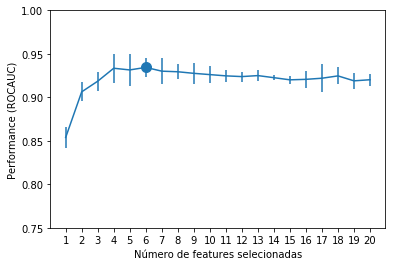

In [14]:
plt.errorbar(df_cv.param_selectktop__K, df_cv.mean_test_score, 1.96*df_cv.std_test_score)
plt.scatter(cv_best.param_selectktop__K, cv_best.mean_test_score, s=100)
plt.ylim(0.75, 1)
plt.xlabel('Número de features selecionadas')
plt.xticks(df_cv.param_selectktop__K.astype(int))
plt.ylabel('Performance (ROCAUC)')
plt.show()

*No nosso experimento controlado, encontramos algumas poucas variáveis a mais do que o correto.*

In [17]:
grid.best_estimator_.steps[0][1].get_feature_names_out()

array(['column_1', 'column_2', 'column_3', 'column_4', 'column_6',
       'column_10'], dtype=object)

*Vale citar que esse método pode ser deixado mais robusto variando o `random_seed` do `base_estimator` e tendo uma distribuição de importâncias para cada variável ao invés de apenas um valor único (que é mais ruídoso). Além disso, recomendo utilizar SHAP para medir a importância nesse caso.*

## Selecionando as `K` melhores incluindo uma variável aleatória

Ao criar uma variável de ruído, ou seja, que sabidamente não é útil para a previsão, teremos um ponto de corte para filtro das variáveis que demonstram ajudar na previsão. A ideia dessa abordagem é medir a importância da variável aleatória e ficar apenas com variáveis que se demonstraram mais importantes.

Adicionando a nova coluna, por exemplo, amostrada de uma variável aleatória $\mathcal{N}(0,1)$ de forma independente, temos uma nova lista de importância das variáveis.

In [28]:
noised_X = (X.assign(noise_column = np.random.RandomState(42).normal(size=X.shape[0])))
noised_X[noised_X.columns[::-1]].head()

,noise_column,column_20,column_19,column_18,...,column_4,column_3,column_2,column_1
0,0.496714,-0.491636,0.209659,1.238946,...,1.009796,0.912474,-1.323568,-1.050478
1,-0.138264,1.121031,-0.822420,0.152355,...,1.850430,1.777419,-2.747104,-1.580834
2,0.647689,-0.137372,0.850898,0.193590,...,0.631813,0.501004,-0.614600,-0.885704
3,1.523030,1.203884,0.615771,-0.316073,...,1.924410,1.884777,-2.967793,-1.525438
4,-0.234153,-1.138833,0.622207,0.300474,...,0.885267,0.752233,-1.014619,-1.076826


In [29]:
noised_rfc = RandomForestClassifier(random_state=42).fit(noised_X, y)

df_imp_normal_noise = \
(pd.DataFrame(list(zip(noised_X.columns, noised_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
)

df_imp_normal_noise

,feature_name,feature_importance
1,column_2,0.266446
2,column_3,0.205667
3,column_4,0.087548
...,...,...
4,column_5,0.018706
18,column_19,0.018264
19,column_20,0.017692


Como a última variável é a nossa coluna sabidamente ruídosa, a ideia dessa técnica é selecionar apenas as variáveis que tem importância maior do que o limiar settado pela importância da variável não relacionada.

In [38]:
np.array(
 df_imp_normal_noise
 .query(f"feature_importance > {noised_rfc.feature_importances_[-1]}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_6',
       'column_10', 'column_14'], dtype=object)

Vale observar que a escolha da variável ruídosa como $\mathcal{N}(0,1)$ foi totalmente arbitrária. Entretanto isso faz diferença e pode fazer a seleção de variáveis ser diferente. No nosso exemplo controlado, mudar o ruído para $\textrm{Exp}(1)$ nos faria selecionar variáveis finais diferentes, totalmente por sorte.

In [39]:
noised2_X = (X.assign(noise_column = np.random.RandomState(42).exponential(size=X.shape[0])))
noised2_rfc = RandomForestClassifier(random_state=0).fit(noised2_X, y)

np.array(
 pd.DataFrame(list(zip(noised2_X.columns, noised2_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .query(f"feature_importance > {noised_rfc.feature_importances_[-1]}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_14',
       'column_6', 'column_10', 'column_9'], dtype=object)

Isso nos demonstra um problema desse método. Apesar de poderoso, por nos dar um jeito interessante de selecionar as variáveis sem escolher `K` de forma arbitrária, a escolha da distribuição da variável ruídosa é uma fonte de variação relevante.

Em muitos casos, ter variáveis discretas *versus* contínuas pode influenciar na medida de importância (como é o caso de árvores que, por ter mais quebras disponíveis, vai ter mais chance de escolher uma variável ruídosa) ou a própria escala da feature adicionada pode atrapalhar nessa mensuração (por exemplo, por estarmos usando os coefiencientes angulares de um [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).

Toda essa variabilidade pode fazer uma *feature* ruim ser selecionada as vezes e em outras vezes uma variável boa ser discartada simplemente por azar.

O Boruta vem para tentar lidar com essas duas questões ao mesmo tempo: tentar manter a distribuição marginal das features ruídosas iguais às distribuições marginais das features originais, enquanto tenta ser robusto à variabilidade, repetindo o experimento algumas vezes.

## Boruta

Já existem muitos textos úteis que explicam o Boruta de forma didática e com exemplos. Como a ideia desse post não é ser redundante com a literatura e sim compilar ideias centrais de uso prático, vamos apenas citar os principais aspectos e deixar o convite para uma leitura detalhada de outras referências do tema como o post [Boruta Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a). A construção que fizemos anteriormente vão deixar as ideias do Boruta ainda mais claras, justificando o modo de serem.

## Boruta main ideas

- Boruta tries to solve this inconsistency repeating the process many times.

- At each time, we write down if the feature was better than an noised one or not (in the sense of having better feature importance than it).

- For each feature, we then apply an statiscal test to test the hypothesis: *"does this feature has 50% chance of beeing better than a noised feature?"*.

- The result of this test gives us 3 regions: the ones that we are certain to be better than randomness, the ones that we are certain that are just bad features and the ones we are not confident enough to but in the other classes.

- PS: to be fair, Boruta creates the features in an different way than we did in this example. Instead of creating then from scratch, using a new random variable, we just shuffle the columns of the original dataframe. In Boruta literature they are called *shadow variables* instead of *noised*.

Our discussions solidified the ideas needed for you to understand Boruta in the details. You can dive deeper now with this [excellent blog post](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a).

## Using Boruta

The [post](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a) gives a pretty way of using the BorutaPy library. Im just adding some comments.

In [ ]:
from boruta import BorutaPy

### Initialize model we want to use as base estimator

- Note that we can add hyper-parameters we find relevant, such as `class_weight`.

- When using tree ensembles (let's be honest, always), deeper trees will change slightly the feature_importance methods and will just take longer to compute. In practice, setting `max_depth` as an int is a time saver with not very much loss in performance of the selection because we will be able to set number of boruta trails bigger because of it. Default RandomForests are expanded until all leaves are pure or until all leaves contain less than min_samples_split (default is set to 1) samples which is very computational consuming.

In [ ]:
forest = RandomForestClassifier(max_depth=7, random_state=42)

### Set Boruta object and fit it

- Boruta's `n_estimators` overwrites the estimator's `n_estimators`. By default, it's set to 1000. If 'auto', then it is determined automatically based on the size of the dataset.
- `alpha` and `perc` are parameters you may want to tune a little.

In [ ]:
boruta = BorutaPy(
   estimator = forest,
   max_iter = 100, # number of trials to perform
   random_state = 42
)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))

### Get the selected features and the ones we are not sure we can safely drop

In [ ]:
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

In [ ]:
green_area

In [ ]:
blue_area

___

___

## Sequential Selector

O primeiro algoritmo que iremos discutir é a técnica de seleção sequencial. A ideia aqui é utilizar uma estratégia gulosa para explorar o número de combinações possíveis de variáveis que temos disponível. A príncipio, temos `2**N_FEATURES` formas diferentes de escolher as `N_FEATURES` disponíveis. Construir todos esses `2**N_FEATURES` modelos é impraticavel. No nosso simples exemplo, com apenas 20 features, teríamos `1048576` combinações diferentes. Se cada modelo demorasse 1 segundo para ser treinado e avaliado, esperaríamos 12 dias até termos todos esses resultados. Com 5 features a mais, teríamos que esperar mais de 1 ano.

A ideia da busca gulosa é escolher uma feature de cada vez para ser adicionada (ou removida) da lista de features selecionadas e observar a mudança na performance do modelo.

Por exemplo, na direção "para frente", podemos comparar o modelo sem nenhuma variável (por exemplo um modelo que retorna alguma estatística dos `y_train`, como a moda, no caso de claissificação, ou uma média/mediana no caso de uma regressão) como todos os `N_FEATURES` modelos possíveis com 1 variável. A variável do modelo que tiver a melhor performance entre os `N_FEATURES` modelos de 1 variável é escolhida para ser a primeira variável selecionada. Para escolher a possível segunda variável, fazemos a mesma coisa comparando 


```python
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator, direction = "forward", n_features_to_select=3)
# other optionfor direction: "backward"
sfs.fit(X, y)
feature_mask = sfs.get_support()
X_selected_features = sfs.transform(X)
```

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion (one feature at a time).

Cons: Even with the greedy approach, it's expensive.

## Variance Selector

```python
from sklearn.feature_selection import VarianceThresholdn

selector = VarianceThreshold()
selector.fit(X)
X_selected_features = selector.transform(X)
```

Feature selector that removes all low-variance features.

Cons: which threshold to pick?

## K-Best Selector

SelectKBest is probably the most common technique. We simply select features according to the k highest scores (some measure of feature importances).

For instance, you can take the most "correlated" features to the target:
```python
from sklearn.feature_selection import SelectKBest, mutual_info_regression

X_selected_features = SelectKBest(mutual_info_regression, k=20).fit_transform(X, y)

```

In practice, we normaly use it with some model measure of feature importances.

### SelectorMixin pro variável ruído:

In [40]:
from scipy.stats import norm

In [54]:
# norm(loc=10, scale=3).rvs(size=1000, random_state=42)

array([11.49014246,  9.5852071 , 11.94306561, 14.56908957,  9.29753988,
        9.29758913, 14.73763845, 12.30230419,  8.59157684, 11.62768013,
        8.60974692,  8.60281074, 10.72588681,  4.26015927,  4.8252465 ,
        8.31313741,  6.96150664, 10.942742  ,  7.27592777,  5.7630889 ,
       14.39694631,  9.3226711 , 10.20258461,  5.72575544,  8.36685183,
       10.33276777,  6.54701927, 11.12709406,  8.19808393,  9.12491875,
        8.19488016, 15.55683455,  9.95950833,  6.82686721, 12.46763474,
        6.33746905, 10.62659079,  4.12098963,  6.01544185, 10.59058371,
       12.21539974, 10.51410484,  9.65305515,  9.09668891,  5.56443403,
        7.84046737,  8.61808369, 13.17136668, 11.03085487,  4.71087953,
       10.97225191,  8.84475316,  7.969234  , 11.83502887, 13.09299857,
       12.79384036,  7.48234743,  9.07236287, 10.99379029, 12.92663538,
        8.56247729,  9.44302307,  6.68099508,  6.41138013, 12.43757747,
       14.06872009,  9.78396964, 13.01059869, 11.08490808,  8.06

In [58]:
from typing import Type
from scipy.stats._distn_infrastructure import rv_continuous
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_is_fitted

class SelectAboveNoise(SelectorMixin, BaseEstimator):
    """
    ...

    """

    # não é sklearn API friendly, mas acho útil aqui
    def __init__(self, sampler:Type[rv_continuous], base_estimator=None, random_state=None):
        self.sampler = sampler
        self.base_estimator = base_estimator
        self.random_state = random_state

    def _validate_estimator(self, default):
        if self.base_estimator is not None:
            self.base_estimator_ = self.base_estimator
        else:
            self.base_estimator_ = default
    
    def fit(self, X, y):
        
        X = self._validate_data(
            X,
            dtype=np.float64,
        )
        
        self._validate_estimator(RandomForestClassifier(random_state=self.random_state))
        
        self.base_estimator_.fit(X, y)
        
        self._selected_index_list_ = \
        (pd.DataFrame(list(zip(range(self.n_features_in_), self.base_estimator_.feature_importances_)),
                      columns=['feature_name', 'feature_importance'])
         .sort_values(by='feature_importance', ascending=False)
         .head(self.K)
         .index
         .to_list()
        )
        
        return self
    
    def _get_support_mask(self):
        check_is_fitted(self)
        return np.array([feat in self._selected_index_list_ for feat in range(self.n_features_in_)])
